# KPI Metric Visualization notebook
A visualization notebook that reads the collected metrics from Ceph and uses `seaborn` to explore and visualize our data.

In [1]:
# Import required libraries
import os
import pdb
from tqdm import tqdm
from functools import partial
from collections import defaultdict

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from ipynb.fs.defs.metric_template import CephCommunication

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (15, 5)})

In [2]:
# ## Specify variables

# ## CEPH Bucket variables
# ## Create a .env file on your local with the correct configs
# s3_endpoint_url = os.getenv("S3_ENDPOINT")
# s3_access_key = os.getenv("S3_ACCESS_KEY")
# s3_secret_key = os.getenv("S3_SECRET_KEY")
# s3_bucket = os.getenv("S3_BUCKET")
# s3_path = os.getenv("S3_PROJECT_KEY", "metrics")

# # Specify whether or not we are running this as a notebook or part of an automation pipeline.
# AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv(
    "S3_ENDPOINT", "https://s3-openshift-storage.apps.zero.massopen.cloud/"
)
s3_access_key = os.getenv("S3_ACCESS_KEY", "v3FnruQ78kfeULDjejUB")
s3_secret_key = os.getenv("S3_SECRET_KEY", "kJiDiHXncLJOXbaL7Zeb5Ok+gkLt9sWIa1rWAJa0")
s3_bucket = os.getenv("S3_BUCKET", "opf-datacatalog")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION", True)

In [4]:
# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
available_metric_objs = metrics_bucket.objects.filter(Prefix=s3_path)

In [5]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_metric_objs = defaultdict(list)
dates_available_for_metric_objs = defaultdict(list)

for obj in available_metric_objs:
    
    if obj.key == 'metrics/flake.parquet':
        continue
    
    # split key into prefix "directory", metric name, and filename
    dir_name, metric_obj_name, file_name = obj.key.split("/")
    print(file_name)
    
    if metric_obj_name not in kpis_in_metric_objs:
        print(f"{metric_obj_name} not found in kpis in metric objs")
        # read a sample file to see what kpis are contained in this file
        sample_file = cc.read_from_ceph(f"{dir_name}/{metric_obj_name}", file_name)

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "job", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_metric_objs[metric_obj_name] = kpis
    else:
        print(f"{metric_obj_name} WAS found in kpis in metric objs")

    # update mapping of "metric name": "dates for which data is available"
    date = file_name.split('-', maxsplit=1)[-1].split('.', maxsplit=1)[0]
    dates_available_for_metric_objs[metric_obj_name].append(date)

avg_correlation-2021-4-14.parquet
avg_correlation not found in kpis in metric objs
avg_correlation-2021-4-16.parquet
avg_correlation WAS found in kpis in metric objs
avg_correlation-2021-4-19.parquet
avg_correlation WAS found in kpis in metric objs
avg_correlation-2021-4-29.parquet
avg_correlation WAS found in kpis in metric objs
avg_correlation-2021-5-3.parquet
avg_correlation WAS found in kpis in metric objs
blocked_timed_out-2021-4-14.parquet
blocked_timed_out not found in kpis in metric objs
blocked_timed_out-2021-4-16.parquet
blocked_timed_out WAS found in kpis in metric objs
blocked_timed_out-2021-4-19.parquet
blocked_timed_out WAS found in kpis in metric objs
blocked_timed_out-2021-4-27.parquet
blocked_timed_out WAS found in kpis in metric objs
blocked_timed_out-2021-5-3.parquet
blocked_timed_out WAS found in kpis in metric objs
build_pass_failure-2021-4-14.parquet
build_pass_failure not found in kpis in metric objs
build_pass_failure-2021-4-16.parquet
build_pass_failure WAS fou

## Read KPIs from Ceph and Visualize

In [6]:
# read one of the kpis to plot the selected metrics objects from ceph
metric = cc.read_from_ceph(
    s3_path,
    f"number_of_flakes/number_of_flakes-2021-4-14.parquet",
)
metric.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333,False
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667,False
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000,False
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667,False
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333,False


### Distribution of KPI metrics across different jobs for a given dashboard

Assuming there is a metric df that looks like above, plot something like this:

Given a dashboard (e.g. "redhat-openshift-ocp-release-4.6-informing”), plot the KPI values corresponding to the `Overall` tests for jobs within the dashboard (e.g. plot the Overall `test duration` for “periodic-ci-openshift-release-master-ci-4.6-e2e-aws” vs “periodic-ci-openshift-release-master-ci-4.6-e2e-gcp” vs …)

In [7]:
tabs = metric.tab.unique()
print("\n\n============List of dashboard tabs to choose from: =============== \n\n", tabs)



============List of dashboard tabs to choose from: =============== 

 ['"redhat-assisted-installer"' '"redhat-openshift-informing"'
 '"redhat-openshift-ocp-release-4.1-blocking"'
 '"redhat-openshift-ocp-release-4.1-informing"'
 '"redhat-openshift-ocp-release-4.2-blocking"'
 '"redhat-openshift-ocp-release-4.2-informing"'
 '"redhat-openshift-ocp-release-4.3-blocking"'
 '"redhat-openshift-ocp-release-4.3-broken"'
 '"redhat-openshift-ocp-release-4.3-informing"'
 '"redhat-openshift-ocp-release-4.4-blocking"'
 '"redhat-openshift-ocp-release-4.4-broken"'
 '"redhat-openshift-ocp-release-4.4-informing"'
 '"redhat-openshift-ocp-release-4.5-blocking"'
 '"redhat-openshift-ocp-release-4.5-broken"'
 '"redhat-openshift-ocp-release-4.5-informing"'
 '"redhat-openshift-ocp-release-4.6-blocking"'
 '"redhat-openshift-ocp-release-4.6-broken"'
 '"redhat-openshift-ocp-release-4.6-informing"'
 '"redhat-openshift-ocp-release-4.7-blocking"'
 '"redhat-openshift-ocp-release-4.7-broken"'
 '"redhat-openshift-ocp-

In [8]:
# Select the dashboard and test
tab = '"redhat-assisted-installer"'
test = 'Overall'

In [9]:
# This function takes as an argument the dashboard tab, test name, metric df and the KPI metric
# It plots the distribution of KPI values over time for the different jobs(grids) in a given TestGrid dashboard tab
def plot_grids(tab, test, df, metric_name):
    for grid in df[df['tab']==tab]['grid'].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df['tab']==tab) & \
            (df['grid']==grid) & \
            (df['test']==test)
        ]
        sns.lineplot(x="timestamp", y = metric_name, data = grid_values, legend='brief', label=str(grid))

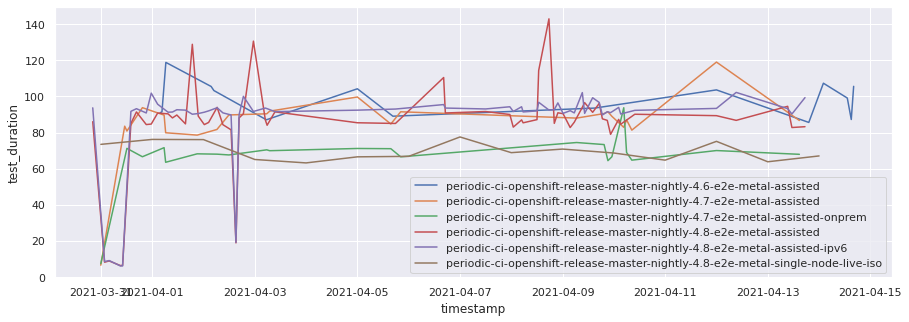

In [10]:
# Here we are plotting the distribution of the test duration metric across different jobs within a given dashboard tab
plot_grids(tab, test, metric, "test_duration")

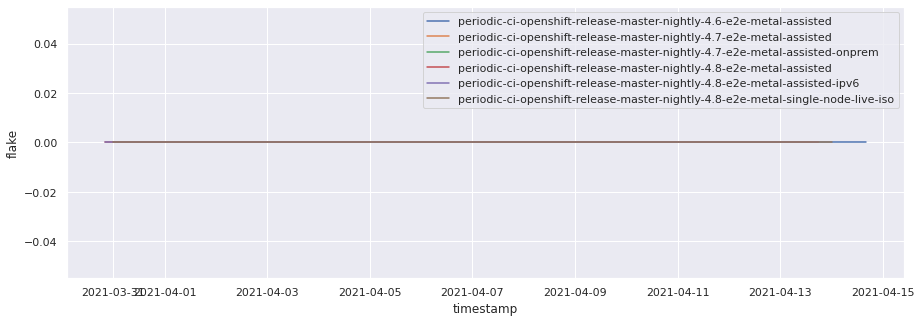

In [11]:
# Here we are plotting the distribution of the Flake severity metric across different jobs within a given dashboard tab
plot_grids(tab, test, metric, "flake")

### Distribution of KPI metrics across different tests for a particular job

Assuming there is a relevant metric df, plot something like this:

Given a job (e.g. “periodic-ci-openshift-release-master-ci-4.6-e2e-gcp”), plot the KPI values for tests within the job (e.g. plot `test duration` for “operator conditions cloud-credential” vs “operator conditions cluster-autoscaler” vs ...)

In [12]:
# For a given dashboard, identify all the jobs (grids)
tab = '"redhat-openshift-ocp-release-4.1-informing"'
grids = metric[metric['tab']==tab]['grid'].unique()
print("\n\n============List of grids to choose from: =============== \n\n", grids)



============List of grids to choose from: =============== 

 ['release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.1-nightly'
 'release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1']


In [13]:
# Select the job(grid)
grid = 'release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1'

In [14]:
df = metric.copy()
df = df[(df['tab']==tab) & (df['grid'] == grid)]
df

,timestamp,tab,grid,test,test_duration,flake
2163889,2021-04-14 00:41:26,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,255.066667,False
2163890,2021-04-13 00:39:54,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,68.900000,False
2163891,2021-04-12 00:38:35,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,61.916667,False
2163892,2021-04-11 00:37:08,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,67.800000,False
2163893,2021-04-10 00:36:09,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,85.800000,False
...,...,...,...,...,...,...
2164634,2021-04-04 00:29:27,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,NaN,False
2164635,2021-04-03 00:28:50,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,NaN,False
2164636,2021-04-02 00:28:12,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,NaN,False
2164637,2021-04-01 00:27:18,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,openshift-tests.Monitor cluster while tests ex...,NaN,False


<AxesSubplot:xlabel='flake', ylabel='count'>

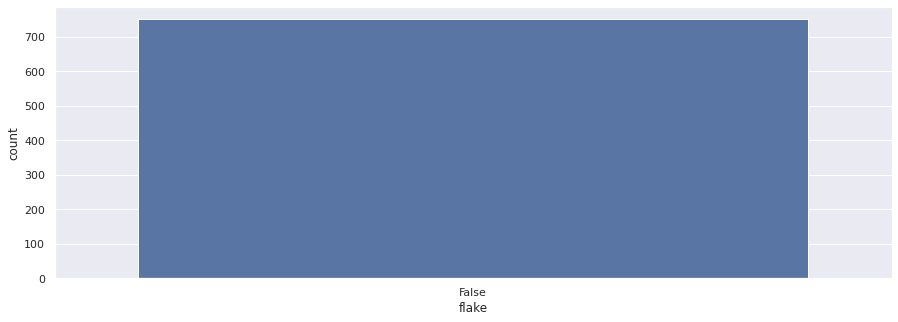

In [15]:
## Count of flakes identified in the tests for a particular grid(job) in a given TestGrid dashboard tab
sns.countplot(x="flake", data=df)

In [16]:
# This function takes as an argument the dashboard tab, grid(job), metric data frame and the KPI metric
# It plots the distribution of KPI values over time for the different tests in a job(grid) of a given TestGrid dashboard tab
def plot_tests(tab, grid, df, metric_name):
    for test in (df[(df['tab']==tab) & (df['grid'] == grid)]['test'].unique()):
        grid_values = pd.DataFrame()
        grid_values = df[
            (df['tab']==tab) & \
            (df['grid']==grid) & \
            (df['test']==test)
        ]
#         plt.figure()
        sns.lineplot(x="timestamp", y = metric_name, data = grid_values, legend='brief')
#         plt.show()

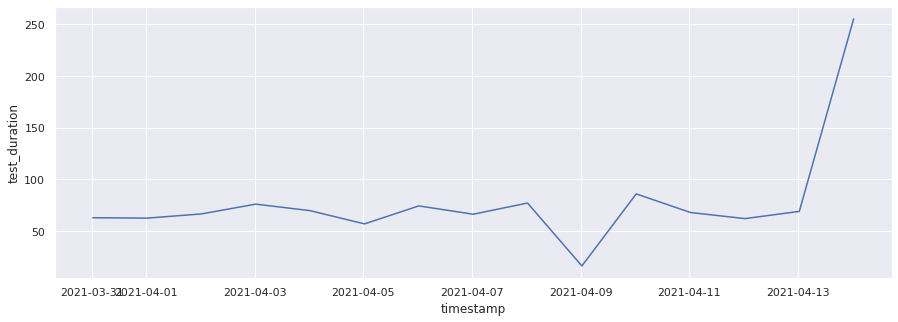

In [17]:
# Here we are plotting the distribution of the test duration metric across different tests within a given dashboard tab
plot_tests(tab, grid, metric, "test_duration" ) 

In [18]:
## The values for "test_duration" are only available for "Overall" hence the above graph shows only one lineplot.

### Variation of KPI metrics over time
We can plot the KPI metric values over time to identify any change, pattern or trend in the values for different grids(jobs) and different tests

In [19]:
# This function takes as an argument the TestGrid dashboard tab, grid(job), metric data frame, the KPI metric name and the title of the graph
# It plots the KPI values over time for the particular grid(job) in a given TestGrid dashboard tab
def plot_metrics_tab_grid(tab, grid, df, metric_name, graph_title):

    """
    Takes in input as tab and grid and plots change in
    KPI metrics over time
    """

    df = df[(df["tab"] == tab) & (df["grid"] == grid)]
    print(df.shape)
    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel("Timestamps")
    plt.ylabel(metric_name)
    plt.title(graph_title)
    plt.show()

(1275, 6)


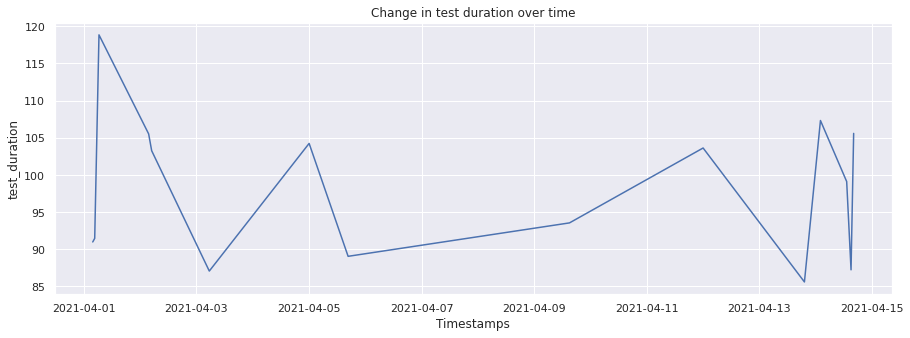

In [20]:
# Select the dashboard tab, grid(job) and the KPI metric you wish to plot the graphs for
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted",
    metric,
    "test_duration",
    "Change in test duration over time"
)

(1748, 6)


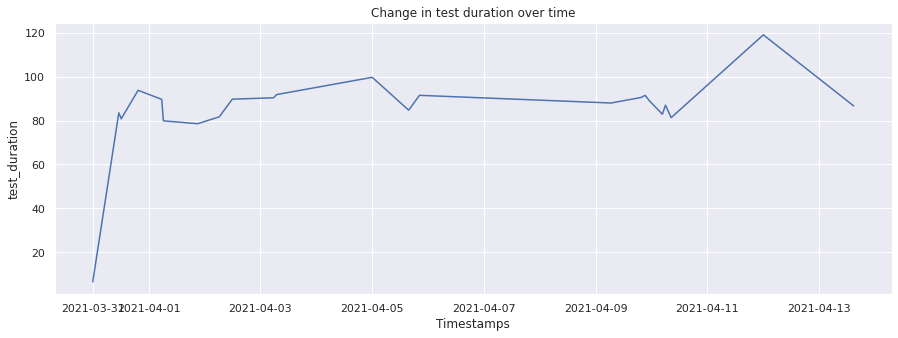

In [21]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    metric,
    "test_duration",
    "Change in test duration over time"
)

(4560, 6)


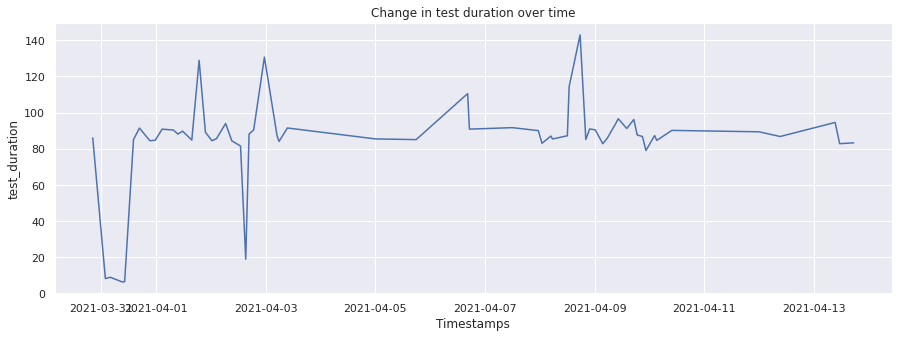

In [22]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted",
    metric,
    "test_duration",
    "Change in test duration over time"
)

(1275, 6)


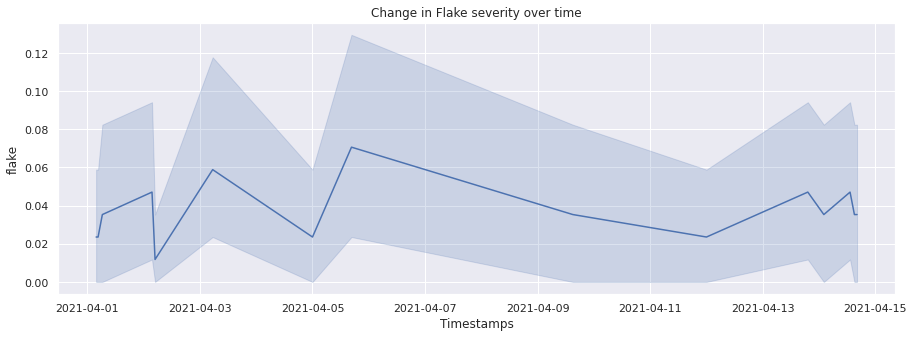

In [23]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted",
    metric,
    "flake",
    "Change in Flake severity over time"
)

(1748, 6)


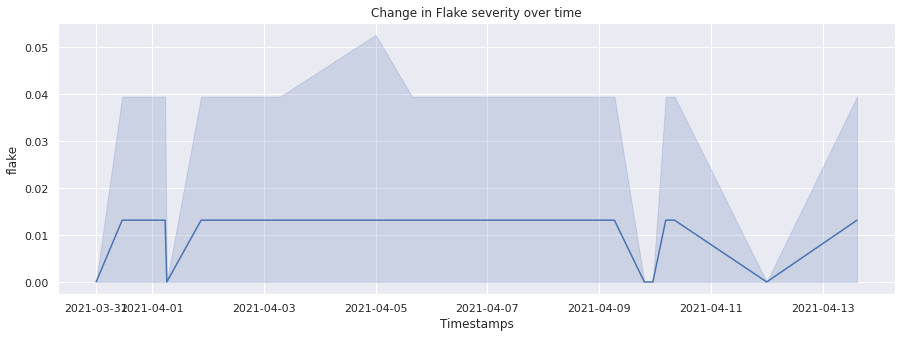

In [24]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    metric,
    "flake",
    "Change in Flake severity over time"
)

(4560, 6)


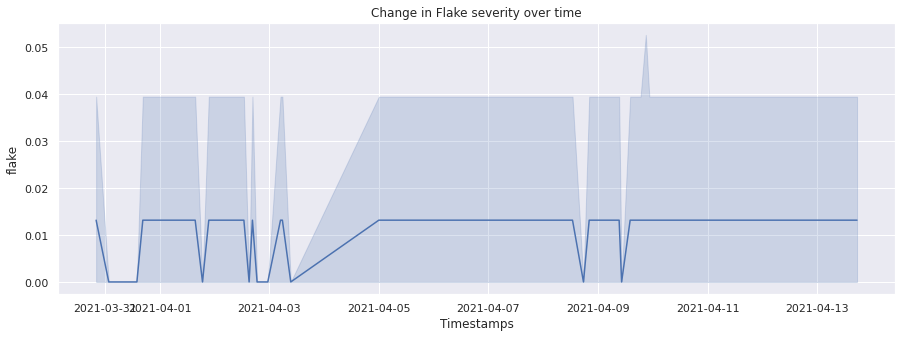

In [25]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted",
    metric,
    "flake",
    "Change in Flake severity over time"
)